In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import warnings
from matplotlib import rcParams

warnings.filterwarnings("ignore")

rcParams["figure.figsize"] = (4, 4)

# Feature extraction and spatial analysis

In [54]:
import pooch

slide = pooch.retrieve(
    url="https://brd.nci.nih.gov/brd/imagedownload/GTEX-11ZUS-2026",
    fname="GTEX-11ZUS-2026.svs",
    path=".",
    known_hash="sha256:10c8fe9e5301eb711aed028c43640ec3273541dad9178c7521d458462acd0c22",
)

In [55]:
from wsidata import open_wsi
import lazyslide as zs

WSI: /Users/yzheng/Projects/LazySlide/docs/source/tutorial/GTEX-11ZUS-2026.svs
Reader: openslide
Dimensions: 42615×49799 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1464, 1711)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
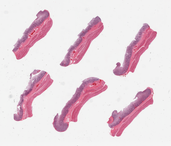

In [56]:
wsi = open_wsi(slide)
wsi

Let's first find and tile the tissue

In [57]:
zs.pp.find_tissues(wsi)
zs.pp.tile_tissues(wsi, 256)

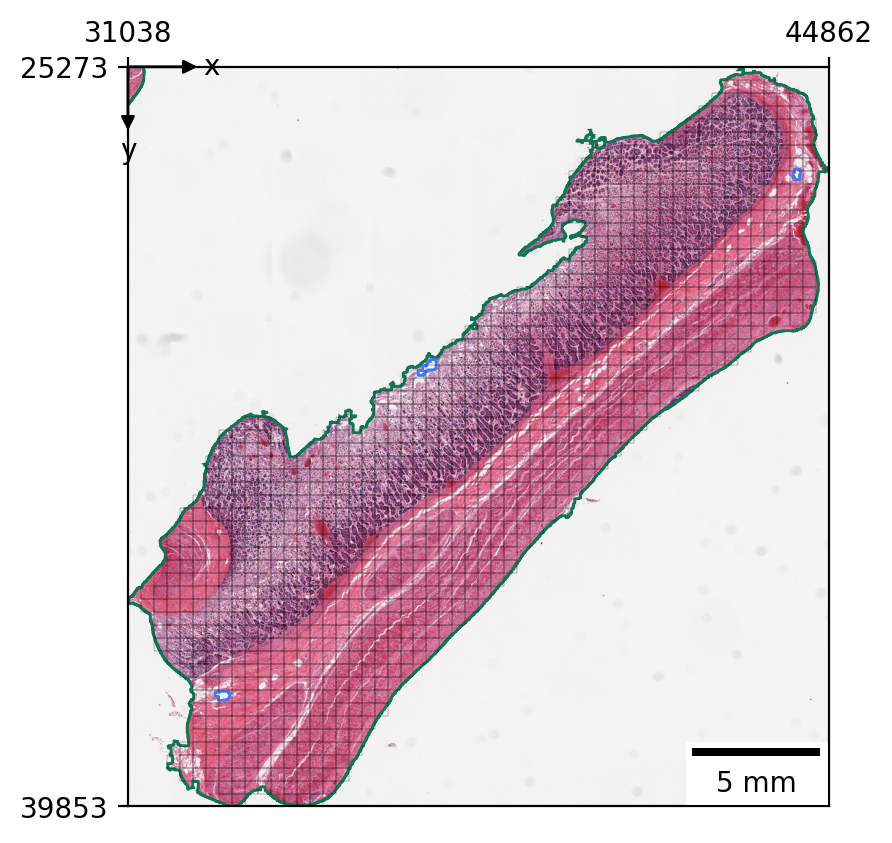

In [58]:
zs.pl.tiles(wsi, tissue_id=0)

## Morphological feature extraction

Feature extraction is to transform the image into a the numeric representation, which comprises of different morphological features. 

Typically, this is done by feeding the tiles into a vision model.

LazySlide supports automatic mix-precision inference, this may reduce memory usuage if you set `amp=True`.

In [60]:
zs.tl.feature_extraction(wsi, "resnet50", amp=True)

Output()

You can easily use foundational models in LazySlide by specifying the name:

Currently supported: 'uni', 'uni2', 'conch', 'conch_vision', 'gigapath'

:::{note}
You need to request access at the the huggingface repository of UNI2 if you want to run the following code. Otherwise, you can use the resnet50 features

In [79]:
zs.tl.feature_extraction(wsi, "uni2", amp=True)

Output()

Features are saved as `AnnData` store with a convention of "{model name}_{tiles key}".

For example, `resnet50_tiles` and `uni2_tiles`

## Feature aggregation

To perform analysis across dataset, a usual way is to pool features into a 1D vector that can represent the entire slide. 

In [80]:
zs.tl.feature_aggregation(wsi, "uni2")

You can retrieve specific feature with the `fetch` accessor. This will return a copy of the anndata.

In [11]:
adata = wsi.fetch.features_anndata("resnet50")

## Identification of spatial domains

If you have experience with scRNA-seq data, the following process should be quite familiar with you.

In [62]:
import scanpy as sc

In [85]:
adata = wsi["uni2_tiles"]
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [82]:
adata

AnnData object with n_obs × n_vars = 6807 × 1536
    obs: 'tile_id', 'library_id'
    uns: 'spatialdata_attrs', 'agg_ops', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'agg_slide', 'PCs'
    obsp: 'distances', 'connectivities'

In [88]:
keys = []
for res in [1.0, 0.5, 0.1]:
    key = f"leiden_{res}"
    keys.append(key)
    sc.tl.leiden(adata, flavor="igraph", resolution=res, key_added=key)

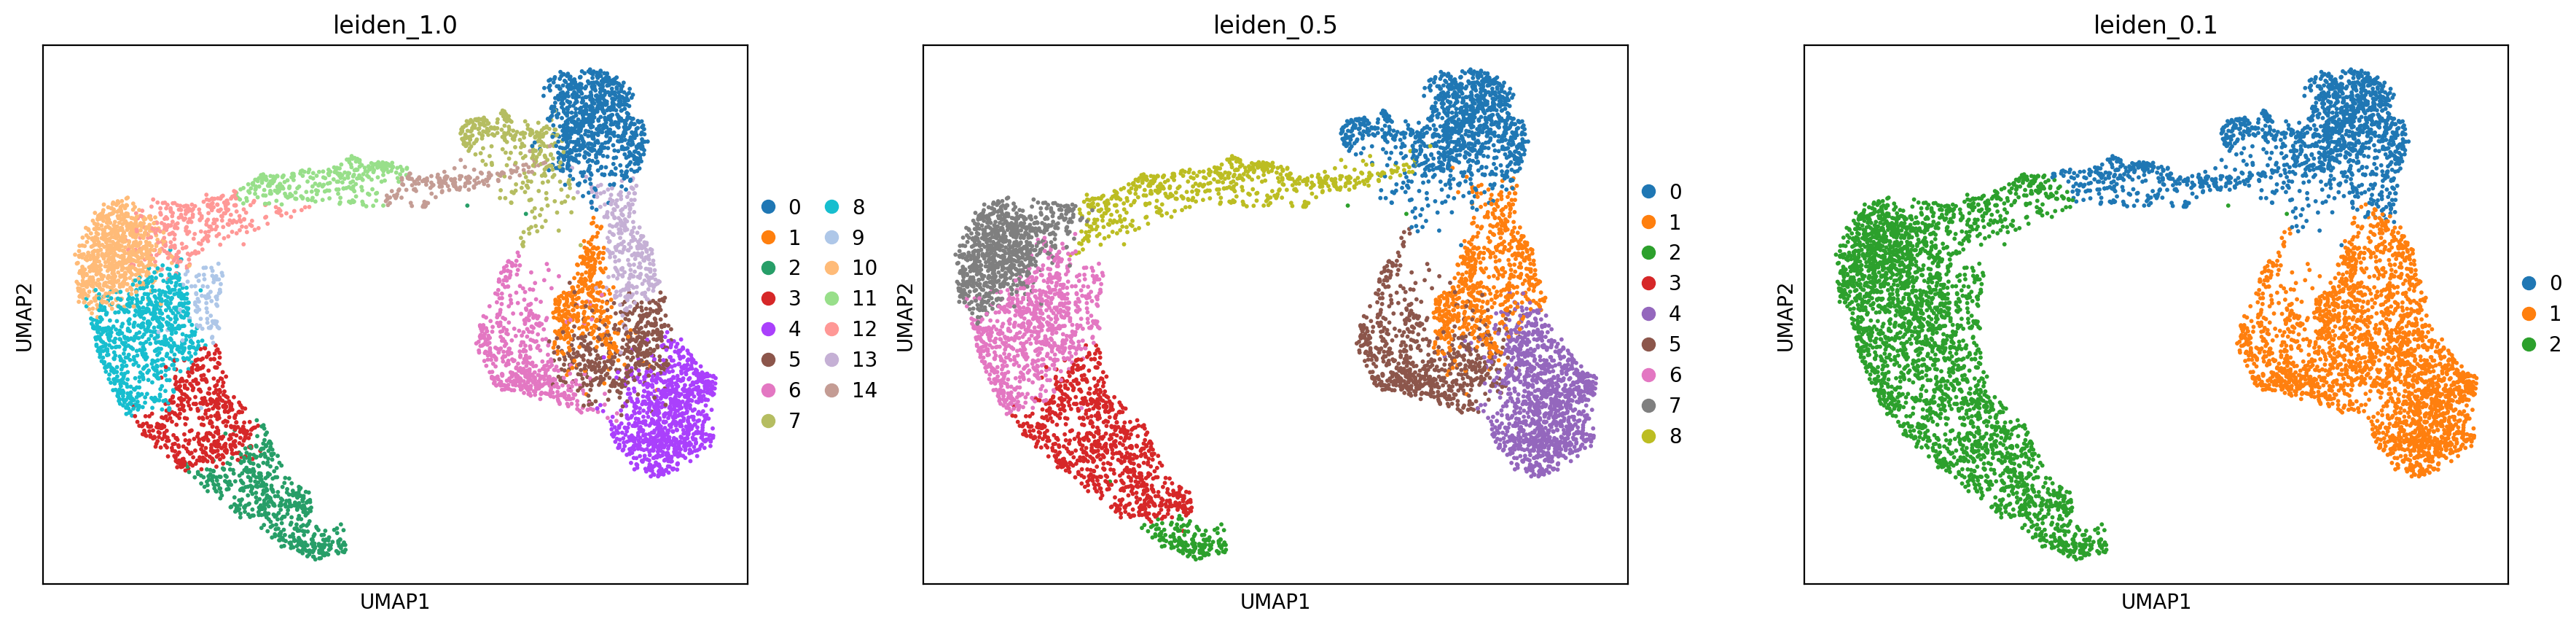

In [89]:
sc.pl.umap(adata, color=keys)

In [86]:
sc.tl.rank_genes_groups(adata, groupby=keys[-1])

In [68]:
names = sc.get.rank_genes_groups_df(adata, "0").names
features = list(names[0:10]) + list(names[-10:])

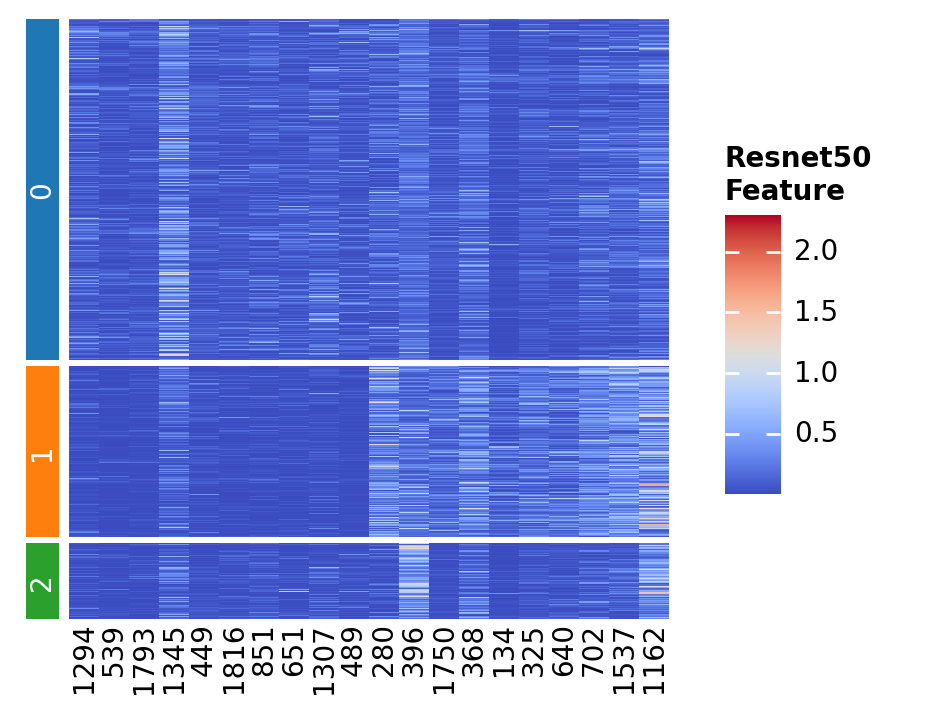

In [69]:
import marsilea as ma
import marsilea.plotter as mp
from scipy.stats import zscore

h = ma.Heatmap(adata[:, features].X, height=3, width=3, label="Resnet50\nFeature")
order = sorted(adata.obs["leiden_0.3"].unique())
h.group_rows(adata.obs["leiden_0.3"], order=order)
h.add_left(mp.Chunk(order, fill_colors=["C0", "C1", "C2"], padding=2), pad=0.05)
h.add_bottom(mp.Labels(features))
h.add_dendrogram("right", linewidth=0.1)
h.add_dendrogram("top")
h.add_legends()
h.render()

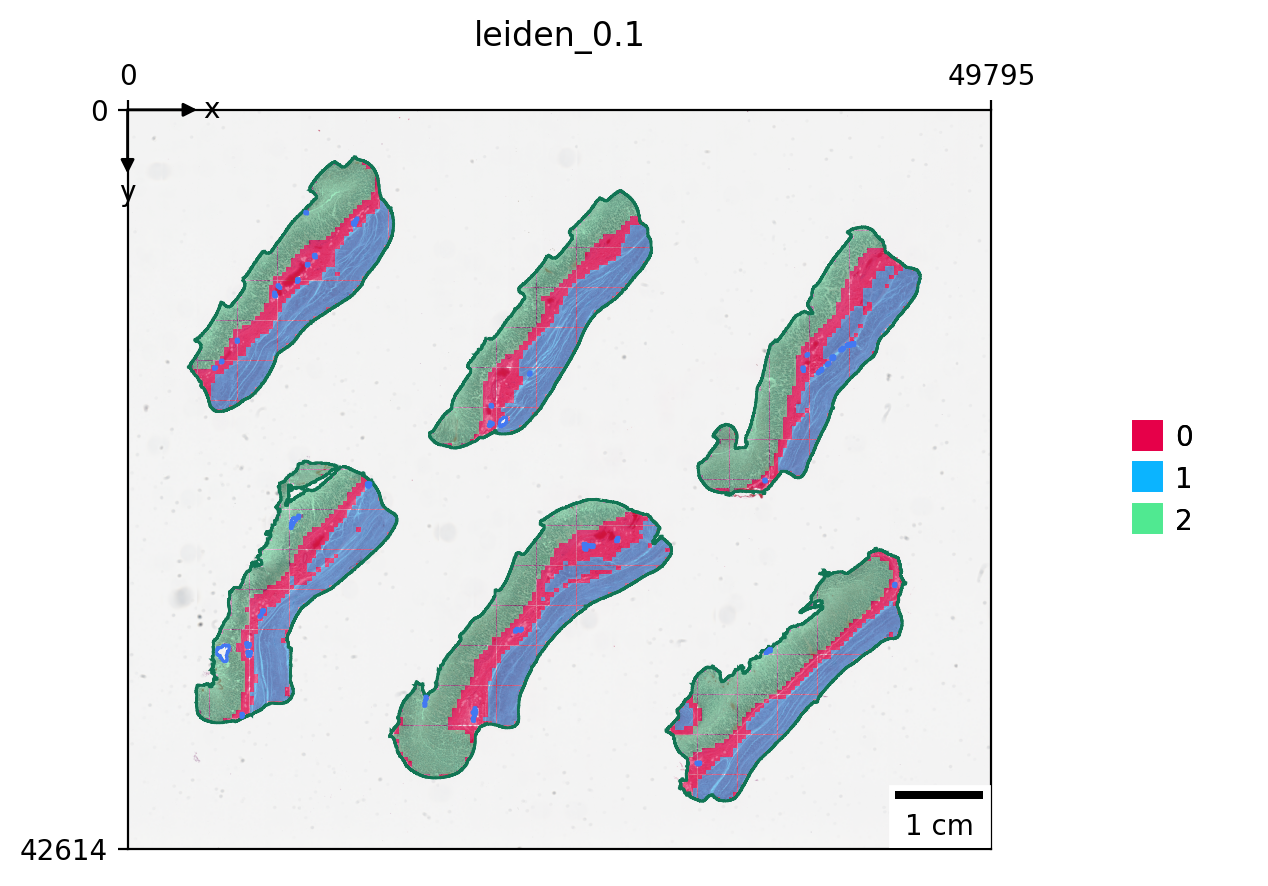

In [90]:
zs.pl.tiles(wsi, feature_key="uni2", color=["leiden_0.1"], alpha=0.5)

In [91]:
wsi.write()

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/yzheng/Projects/LazySlide/docs/source/tutorial/GTEX-11ZUS-2026.zarr                                


## UTAG

[UTAG](https://doi.org/10.1038/s41592-022-01657-2) is a method develop to discovery spatial domain with unsupervised learning

In [92]:
zs.pp.tile_graph(wsi)
zs.tl.feature_utag(wsi, "uni2")

In [93]:
sc.pp.pca(adata, layer="utag")
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [94]:
keys = []
for res in [1.0, 0.5, 0.1]:
    key = f"leiden_{res}"
    keys.append(key)
    sc.tl.leiden(adata, flavor="igraph", resolution=res, key_added=key)

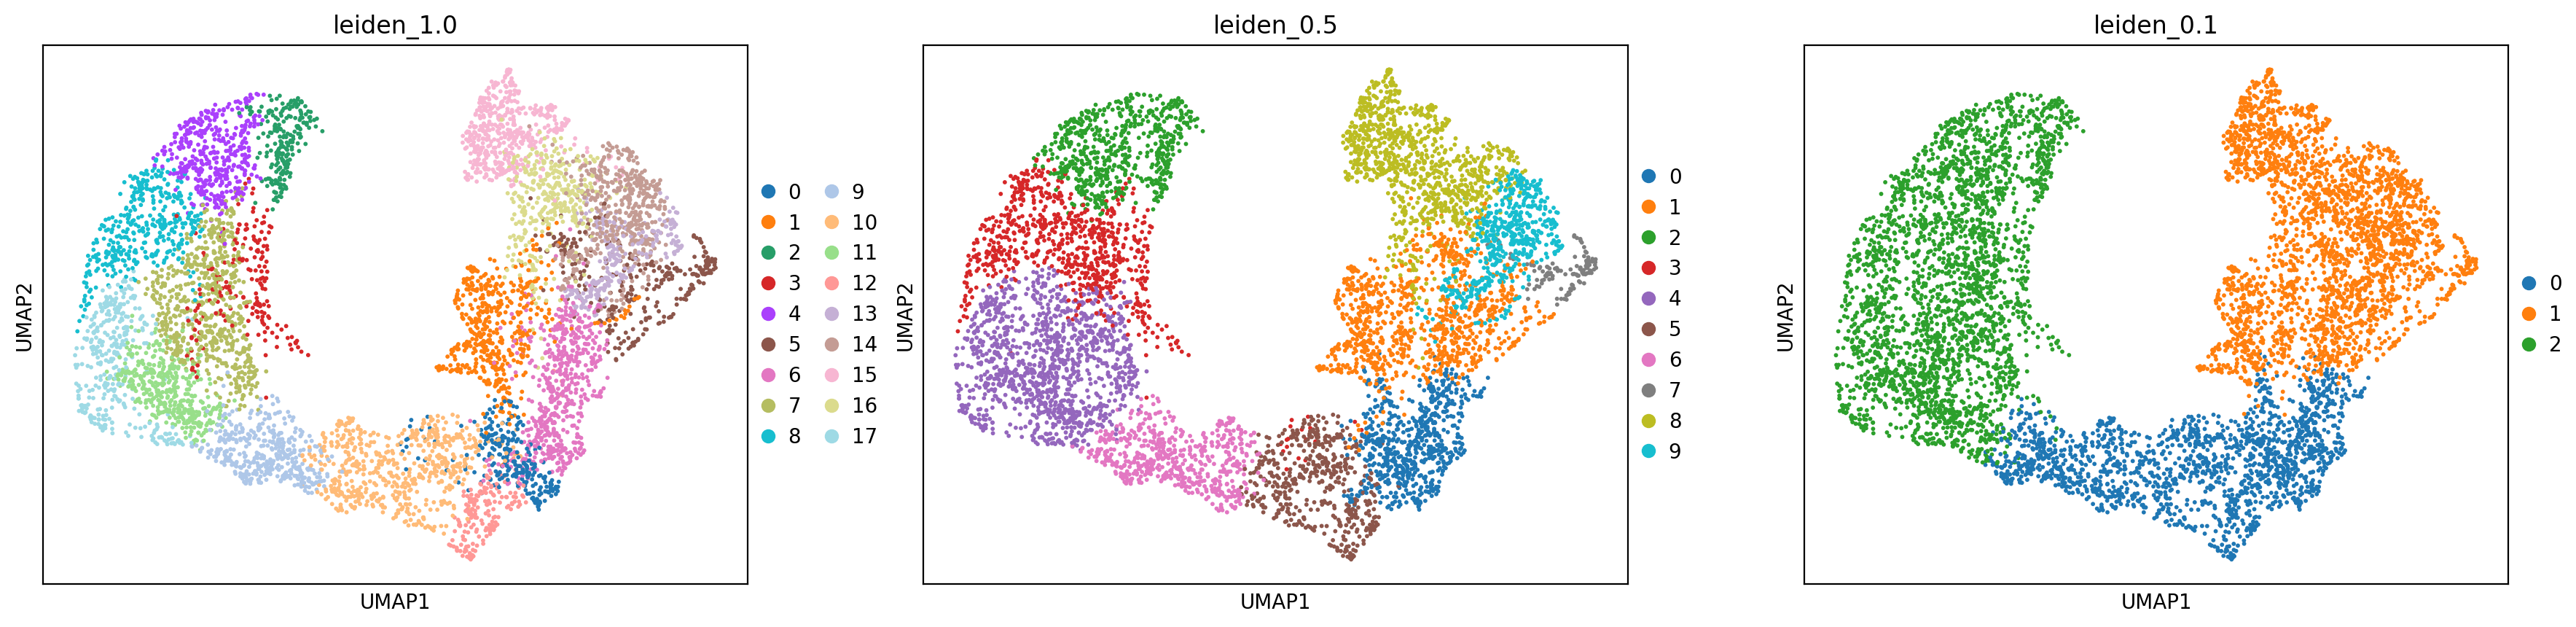

In [95]:
sc.pl.umap(adata, color=keys)

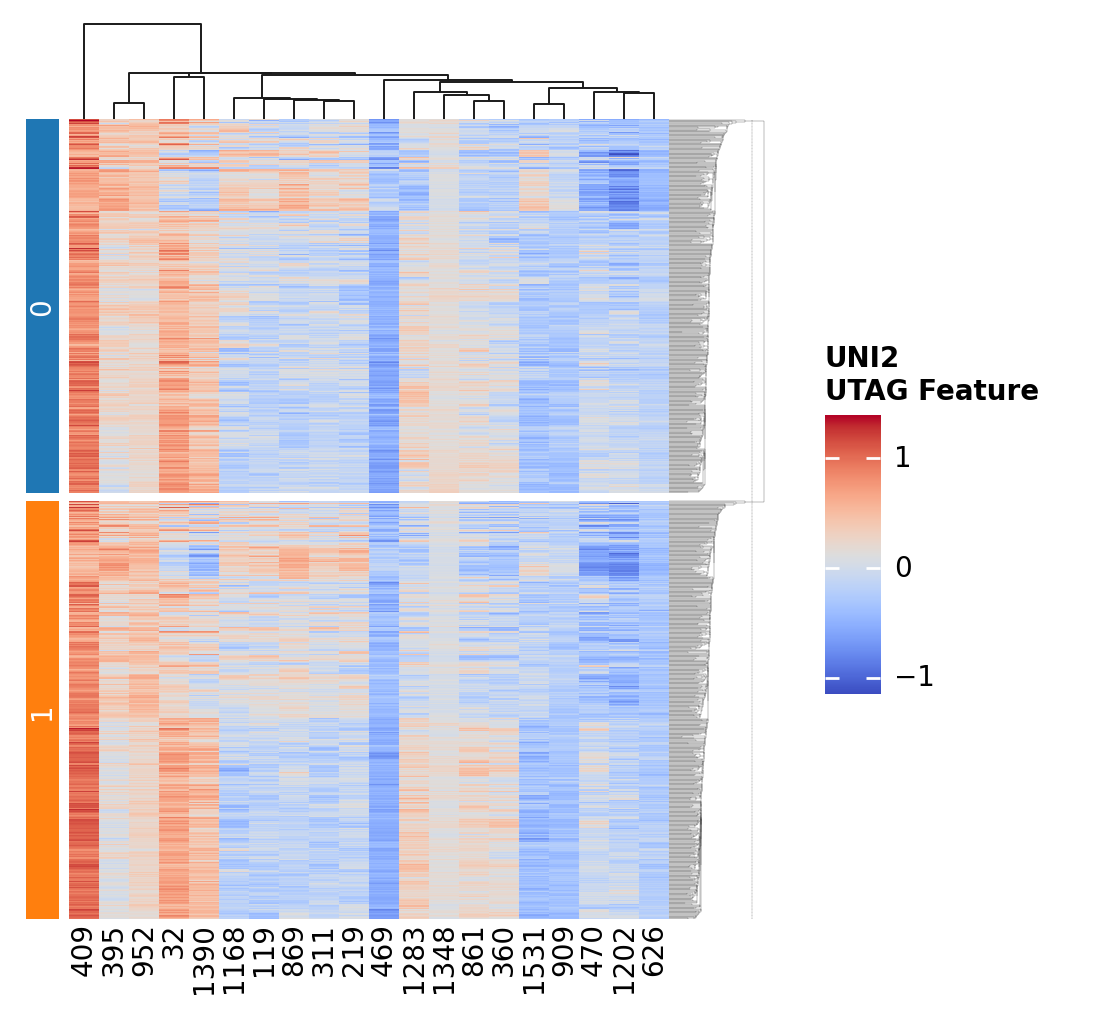

In [69]:
h = ma.Heatmap(adata[:, features].layers["utag"], width=3, label="UNI2\nUTAG Feature")
order = sorted(adata.obs["leiden_0.2"].unique())
h.group_rows(adata.obs["leiden_0.2"], order=order)
h.add_left(mp.Chunk(order, fill_colors=["C0", "C1"], padding=2), pad=0.05)
h.add_bottom(mp.Labels(features))
h.add_dendrogram("right", linewidth=0.1)
h.add_dendrogram("top")
h.add_legends()
h.render()

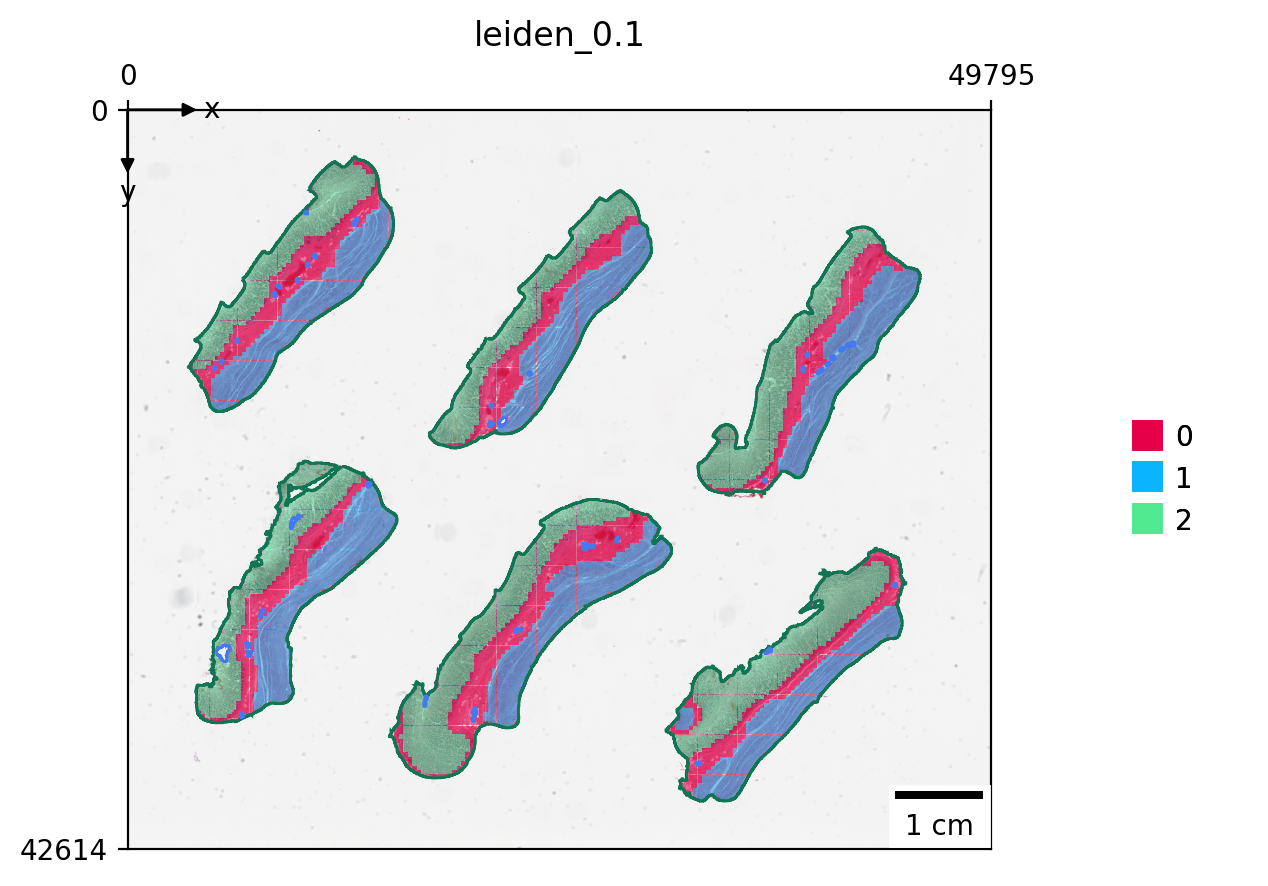

In [96]:
zs.pl.tiles(wsi, feature_key="uni2", color=["leiden_0.1"], alpha=0.5)

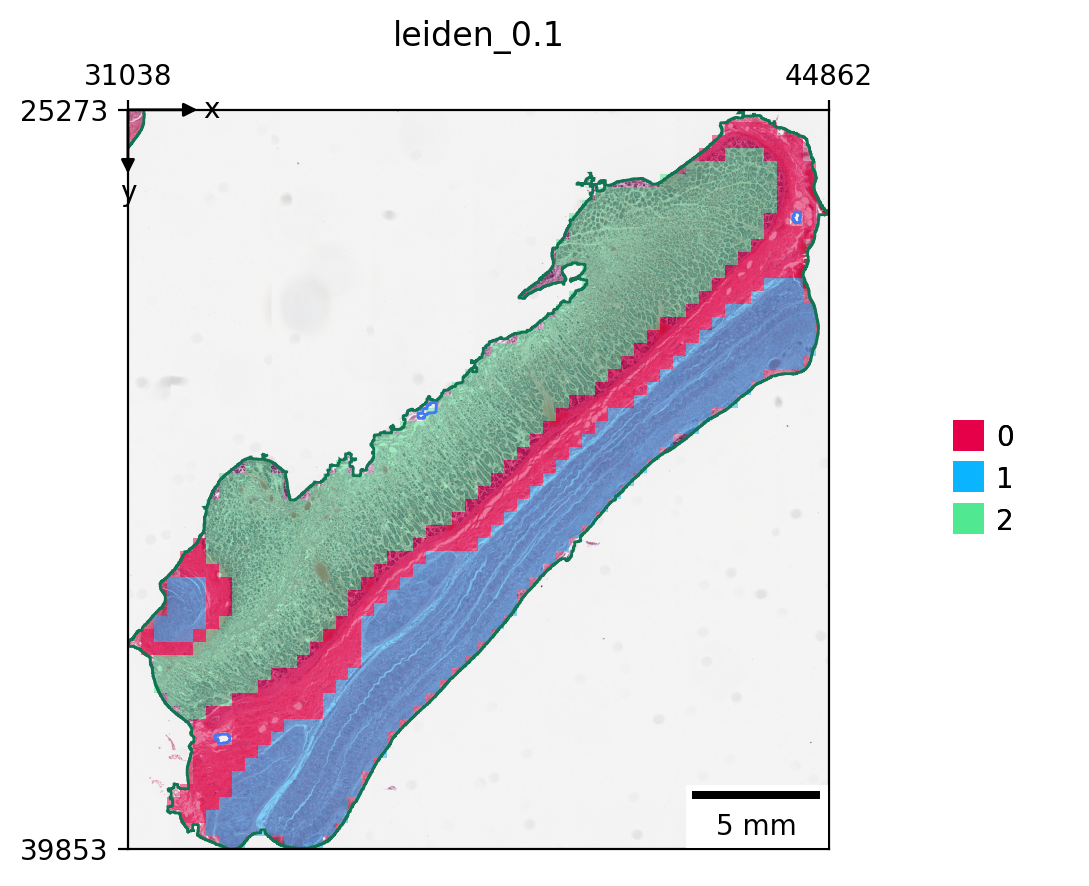

In [97]:
zs.pl.tiles(wsi, feature_key="uni2", color=["leiden_0.1"], alpha=0.5, tissue_id=0)

In [105]:
wsi["tiles"]["name"] = (
    wsi["uni2_tiles"]
    .obs["leiden_0.1"]
    .map(
        {
            "0": "Submucosa",
            "1": "Muscularis",
            "2": "Mucosa",
        }
    )
    .values
)

## Convert rasterized tiles to shapes

You can aggregate the tiles into smooth shapes for future application.

In [108]:
zs.tl.tile_shaper(wsi, groupby="name")

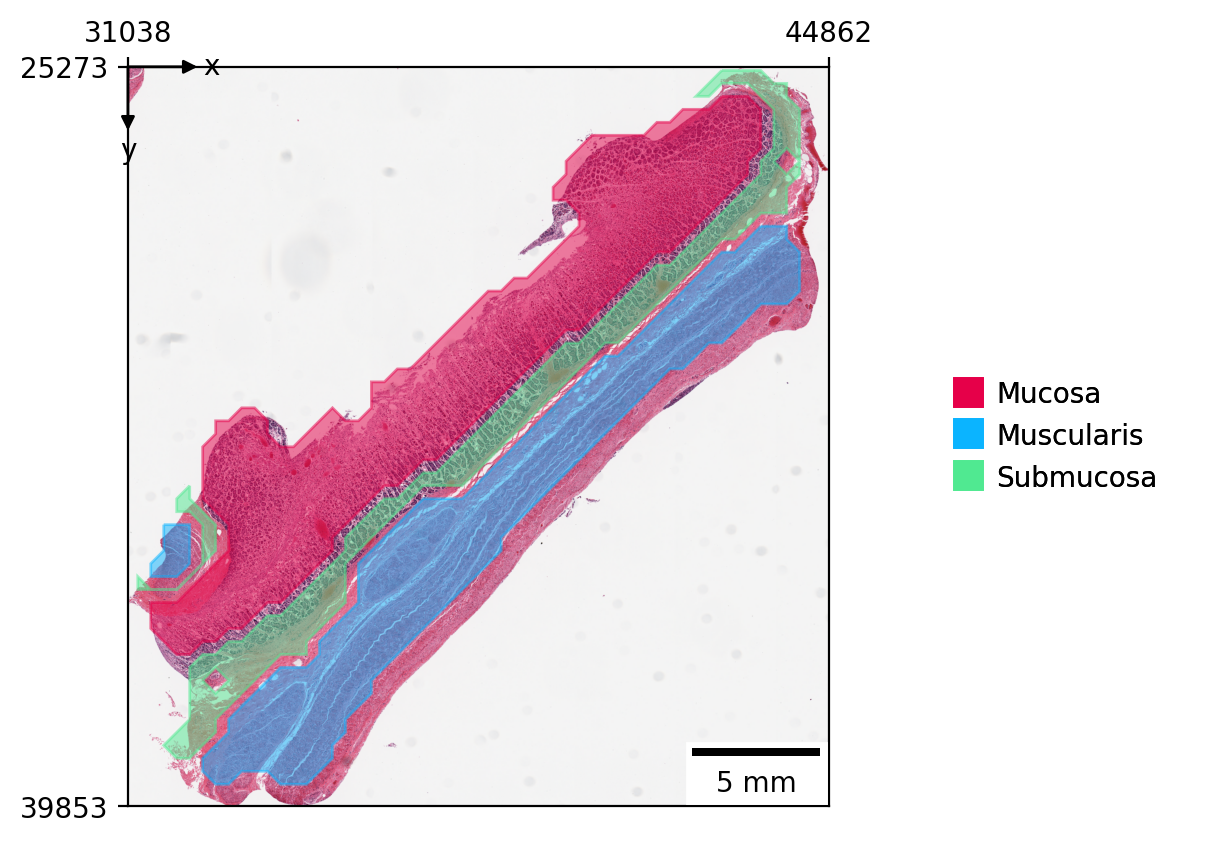

In [113]:
zs.pl.annotations(wsi, "domain_shapes", color="name", tissue_id=0)

## Text feature extraction

Apart from deriving morphological features from vision models, you can also run multimodal to derive text features.

Currently, there are two vision-language models for pathology
- [PLIP](https://doi.org/10.1038/s41591-023-02504-3), Nature Medicine, 2023
- [CONCH](https://doi.org/10.1038/s41591-024-02856-4), Nature Medicine, 2024

In [115]:
zs.tl.feature_extraction(wsi, "plip")

Output()

In [116]:
terms = ["mucosa", "submucosa", "musclaris", "apple"]

embeddings = zs.tl.text_embedding(terms, model="plip")

In [117]:
zs.tl.text_image_similarity(wsi, embeddings)

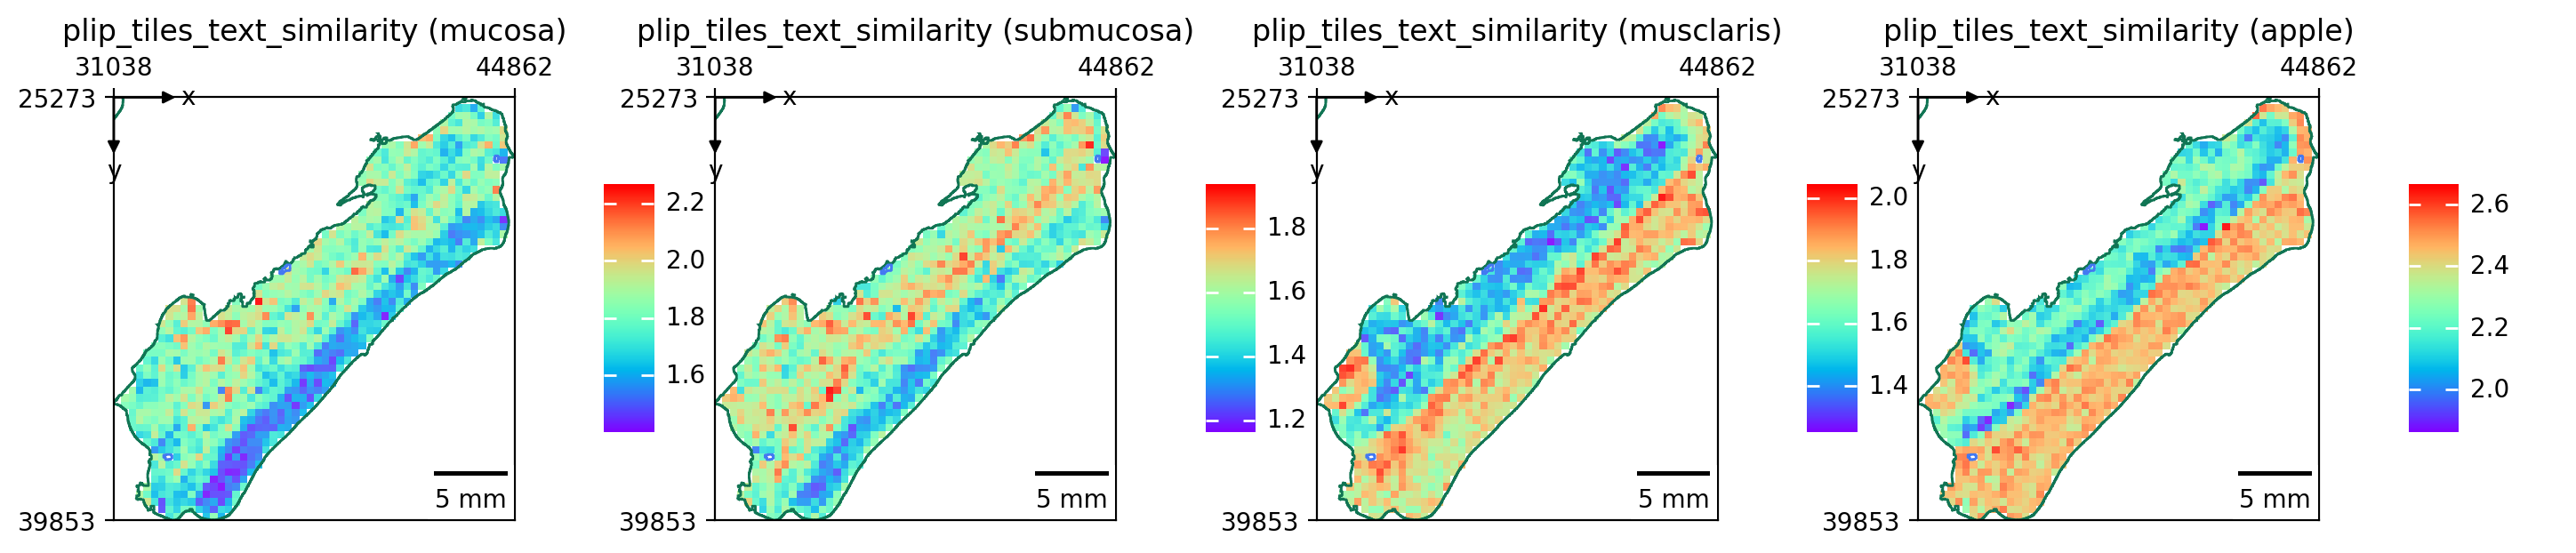

In [120]:
zs.pl.tiles(
    wsi,
    feature_key="plip_tiles_text_similarity",
    color=terms,
    cmap="rainbow",
    show_image=False,
    tissue_id=0,
)